# Tensorflow

## 1.&nbsp; Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

## 2.&nbsp; Parsing the raw data

In [2]:
url = "https://drive.google.com/file/d/1OWsaiEalssU5lMxmhk9-f32zJXP7vY2r/view?usp=sharing"
Solar_PATH = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]

In [3]:
url = "https://drive.google.com/file/d/1q559eD3tZSszFvqVKTa1uZuElDmYFvv9/view?usp=sharing"
Wind_PATH = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]

In [4]:
def parse_data_from_file(filename):
    """Parse data from csv file

    Args:
        filename (str): complete path to file (path + filename)

    Returns:
        (np.ndarray, np.ndarray): arrays of timestamps and values of the time series
    """    
    # Load the production using np.loadtxt. Remember you want to skip the first 
    # row, since it's headers. Make sure to use the correct column of the csv file.
    #production = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=5, dtype=float)
    production_data = np.loadtxt(
        filename, 
        delimiter=",", 
        skiprows=1, 
        usecols=5,
        dtype=str
        #filling_values=np.nan  # Replace missing or empty values with NaN
        #invalid_raise=False      # Skip rows with invalid data
        )
    
    production = np.array(
        [float(val) if val != '' else np.nan for val in production_data]
        )

    # Generate indexes as dates/timestamps instead of reading from a file column.
    date = np.arange(len(production))
        
    return date, production

In [5]:
date_solar, production_solar = parse_data_from_file(Solar_PATH)
date_wind, production_wind = parse_data_from_file(Wind_PATH)

In [6]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

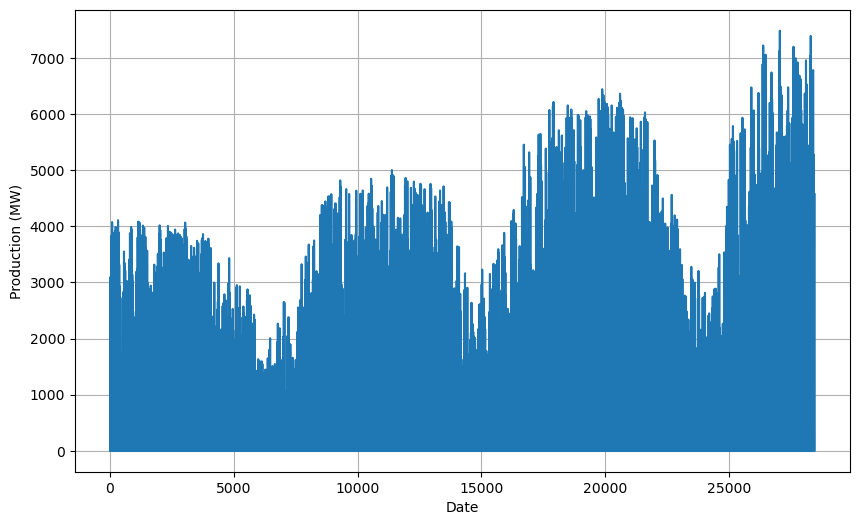

In [7]:
# Preview the data
plot_series(date_solar, production_solar, xlabel='Date', ylabel='Production (MW)')

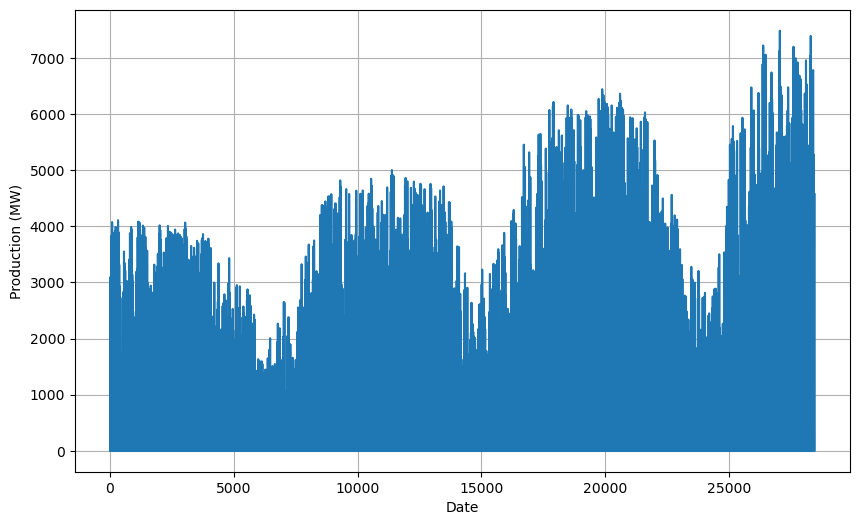

In [8]:
plot_series(date_wind, production_wind, xlabel='Date', ylabel='Production (MW)')

## 3.&nbsp; Seasonal decomposition of time series

In [9]:
df_solar = pd.read_csv(Solar_PATH)
df_wind = pd.read_csv(Wind_PATH)

In [10]:
df_s = df_solar.rename(columns={'Date and Hour' : 'DateTime'})
df_s['DateTime'] = df_s['DateTime'].str.slice(stop=-6)
df_s = df_s.sort_values(ascending=True,by='DateTime')
df_s = df_s.drop(['Date','dayOfYear','dayName','monthName'],axis=1)
solar_df = df_s.dropna()
solar_df['DateTime'] = pd.to_datetime(solar_df['DateTime'])

solar = solar_df[['DateTime','Production']]
solar['DateTime'] = pd.to_datetime(solar['DateTime'])
solar = solar.set_index('DateTime')

In [11]:
df_w = df_wind.rename(columns={'Date and Hour' : 'DateTime'})
df_w['DateTime'] = df_w['DateTime'].str.slice(stop=-6)
df_w = df_w.sort_values(ascending=True,by='DateTime')
df_w = df_w.drop(['Date','dayOfYear','dayName','monthName'],axis=1)
wind_df = df_w.dropna()
wind_df['DateTime'] = pd.to_datetime(wind_df['DateTime'])

wind = wind_df[['DateTime','Production']]
wind['DateTime'] = pd.to_datetime(wind['DateTime'])
wind = wind.set_index('DateTime')

In [12]:
# Set global font size
plt.rcParams.update({'font.size': 16})  # Change 16 to your desired font size

def solar_seasonal_decompose_plotter(df: pd.DataFrame, period=12, title='', figsize=(20, 12)):
    """
    Perform and plot seasonal decomposition of a time series.

    Parameters:
        df: DataFrame with time series data.
        col: Column name for data to decompose. Default is 'sqrt(O3 AQI)'.
        date_col: Column name for datetime values. Default is 'Date'.
        period: Seasonality period. Default is 12.

    Returns:
        A DecomposeResult object with seasonal, trend, and residual components.
    """
    # Decompostion
    decomposition = seasonal_decompose(df.values, period=period)
    de_season = decomposition.seasonal
    de_resid = decomposition.resid
    de_trend = decomposition.trend

    fig, ax = plt.subplots(4, sharex=True, figsize=figsize)

    ax[0].set_title(title)
    ax[0].plot(df.index, df.values, color='C1')
    ax[0].set_ylabel(df.keys()[0])
    ax[0].grid(alpha=0.25)
    
    ax[1].plot(df.index, de_trend, color='C3')
    ax[1].set_ylabel('Trend')
    ax[1].grid(alpha=0.25)
    
    ax[2].plot(df.index, de_season, color='C2')
    ax[2].set_ylabel('Seasonal')
    ax[2].grid(alpha=0.25)

    ax[3].axhline(y=0, color='k', linewidth=1)
    ax[3].scatter(df.index, de_resid, color='C4', s=10)
    ax[3].set_ylabel('Resid')
    ax[3].grid(alpha=0.25)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout(h_pad=0)
    plt.show()
    
    return decomposition

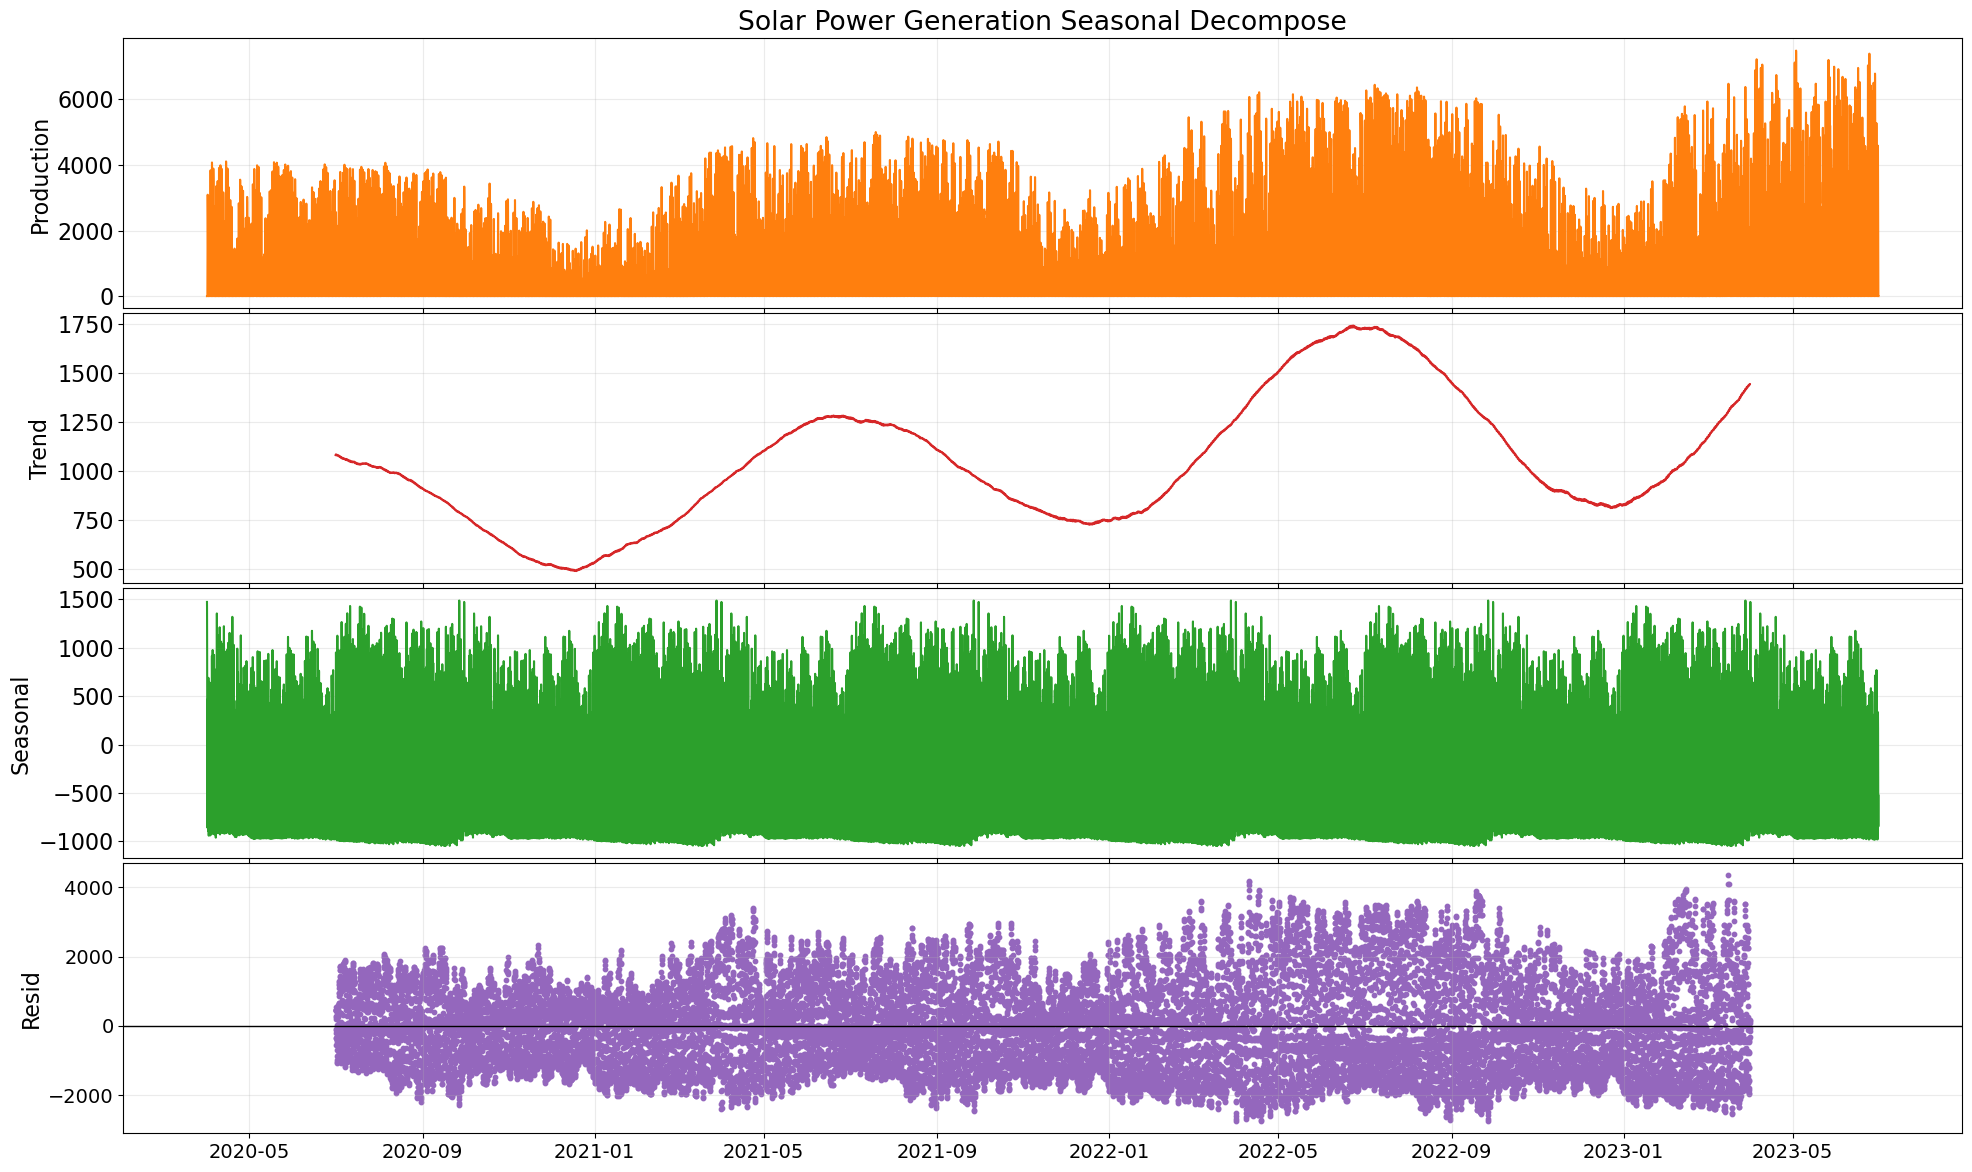

In [13]:
solar_ = solar_seasonal_decompose_plotter(solar, period=365*12, title='Solar Power Generation Seasonal Decompose', figsize=(20, 12))

In [14]:
# Set global font size
plt.rcParams.update({'font.size': 18})  # Change 16 to your desired font size

def solar_seasonal_decompose_plotter2(df: pd.DataFrame, period=12, title='', figsize=(20, 12)):
    """
    Perform and plot seasonal decomposition of a time series.

    Parameters:
        df: DataFrame with time series data.
        col: Column name for data to decompose. Default is 'sqrt(O3 AQI)'.
        date_col: Column name for datetime values. Default is 'Date'.
        period: Seasonality period. Default is 12.

    Returns:
        A DecomposeResult object with seasonal, trend, and residual components.
    """
    # Decompostion
    decomposition = seasonal_decompose(df.values, period=period)
    de_season = decomposition.seasonal
    de_trend = decomposition.trend

    fig, ax = plt.subplots(3, sharex=True, figsize=figsize)

    ax[0].set_title(title, fontsize=20)
    ax[0].plot(df.index, df.values, color='C1')
    ax[0].set_ylabel(df.keys()[0], fontsize=18)
    ax[0].grid(alpha=0.25)
    
    ax[1].plot(df.index, de_trend, color='C3')
    ax[1].set_ylabel('Trend', fontsize=18)
    ax[1].grid(alpha=0.25)
    
    ax[2].plot(df.index, de_season, color='C2')
    ax[2].set_ylabel('Seasonal', fontsize=18)
    ax[2].grid(alpha=0.25)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout(h_pad=0)
    plt.show()
    
    return decomposition

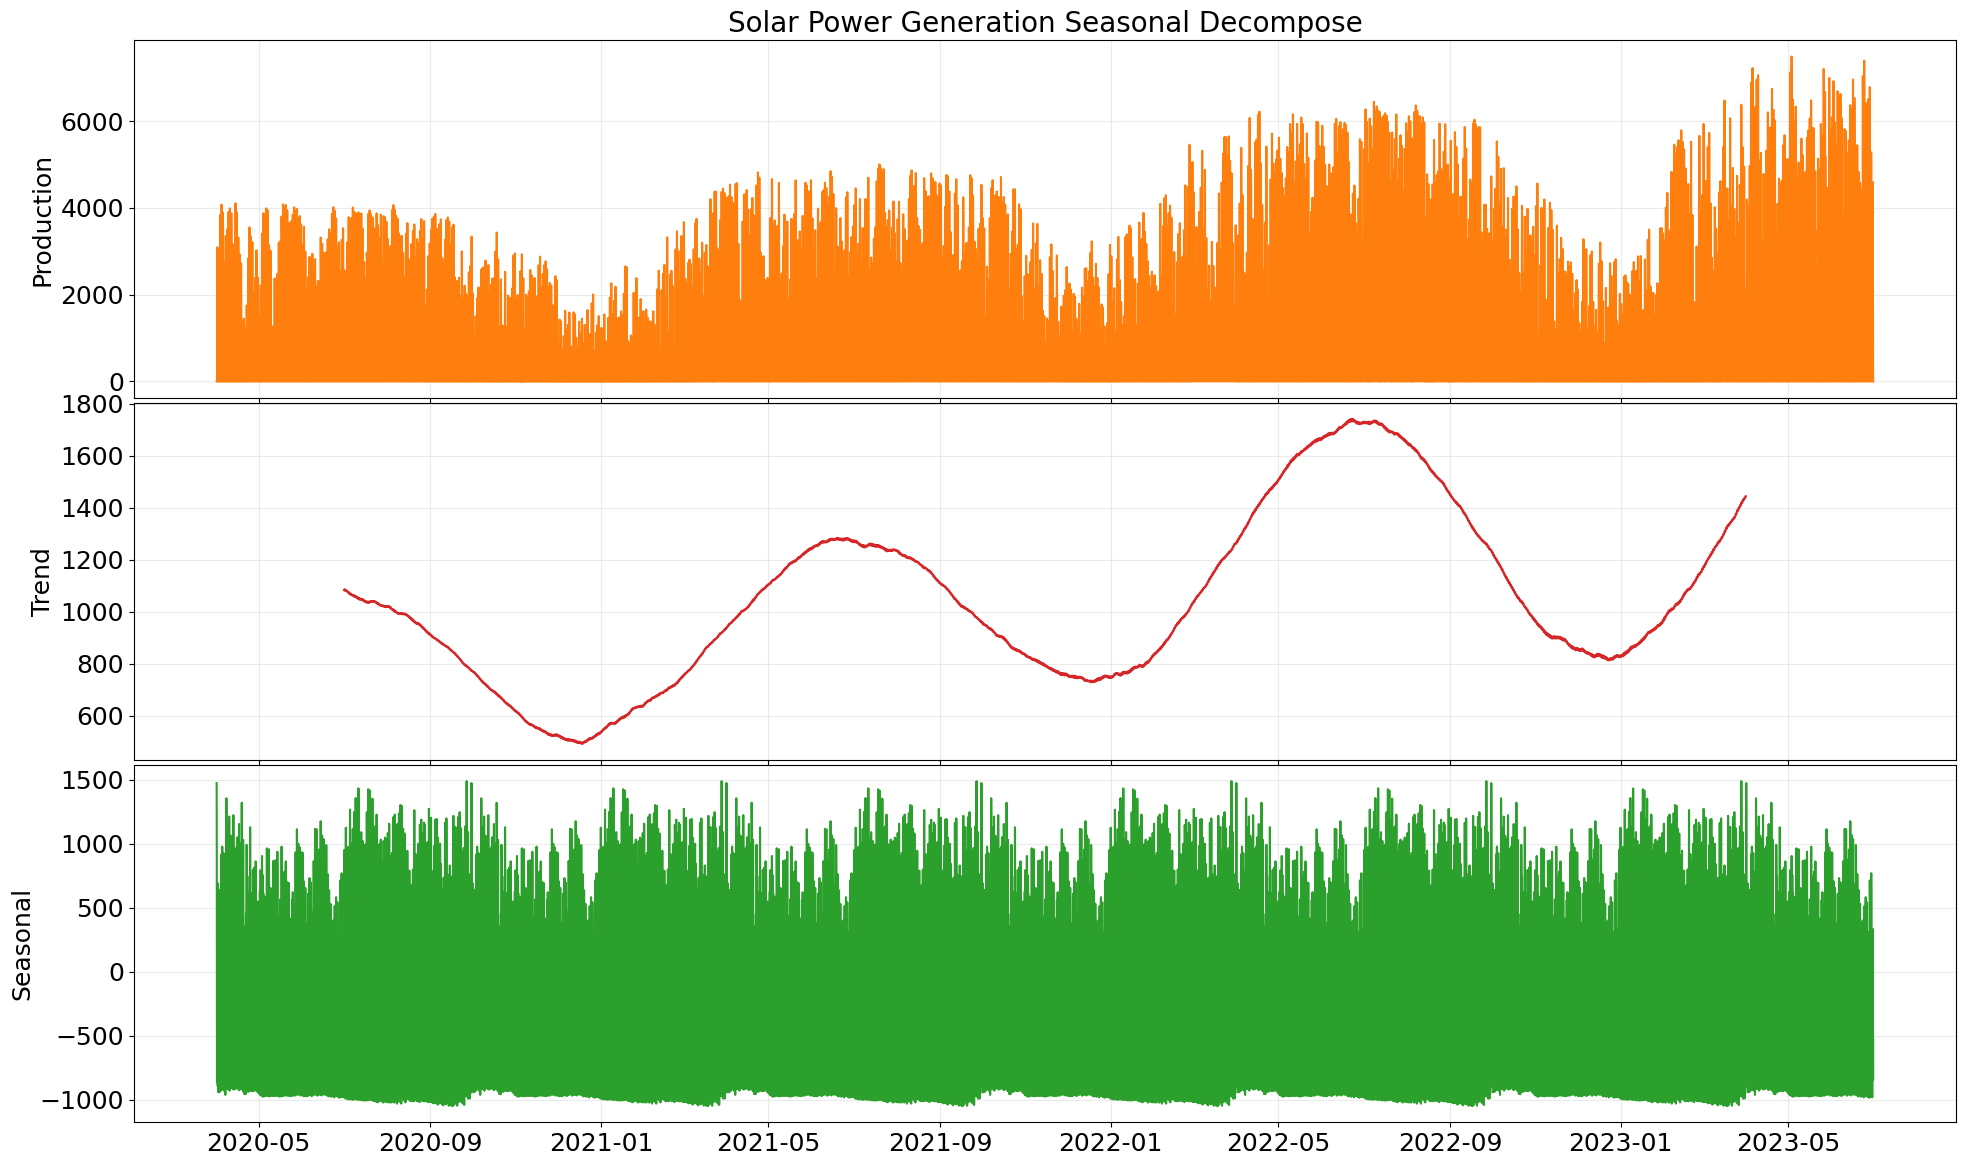

In [15]:
solar_trend = solar_seasonal_decompose_plotter2(solar, period=365*12, title='Solar Power Generation Seasonal Decompose', figsize=(20, 12))

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set global font size
plt.rcParams.update({'font.size': 16})  # Change 16 to your desired font size

def wind_seasonal_decompose_plotter(df: pd.DataFrame, period=12, title='', figsize=(20, 12)):
    """
    Perform and plot seasonal decomposition of a time series.

    Parameters:
        df: DataFrame with time series data.
        col: Column name for data to decompose. Default is 'sqrt(O3 AQI)'.
        date_col: Column name for datetime values. Default is 'Date'.
        period: Seasonality period. Default is 12.

    Returns:
        A DecomposeResult object with seasonal, trend, and residual components.
    """
    # Decompostion
    decomposition = seasonal_decompose(df.values, period=period)
    de_season = decomposition.seasonal
    de_resid = decomposition.resid
    de_trend = decomposition.trend

    fig, ax = plt.subplots(4, sharex=True, figsize=figsize)

    ax[0].set_title(title)
    ax[0].plot(df.index, df.values, color='C0')
    ax[0].set_ylabel(df.keys()[0])
    ax[0].grid(alpha=0.25)
    
    ax[1].plot(df.index, de_trend, color='C3')
    ax[1].set_ylabel('Trend')
    ax[1].grid(alpha=0.25)
    
    ax[2].plot(df.index, de_season, color='C2')
    ax[2].set_ylabel('Seasonal')
    ax[2].grid(alpha=0.25)

    ax[3].axhline(y=0, color='k', linewidth=1)
    ax[3].scatter(df.index, de_resid, color='C4', s=10)
    ax[3].set_ylabel('Resid')
    ax[3].grid(alpha=0.25)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout(h_pad=0)
    plt.show()
    
    return decomposition

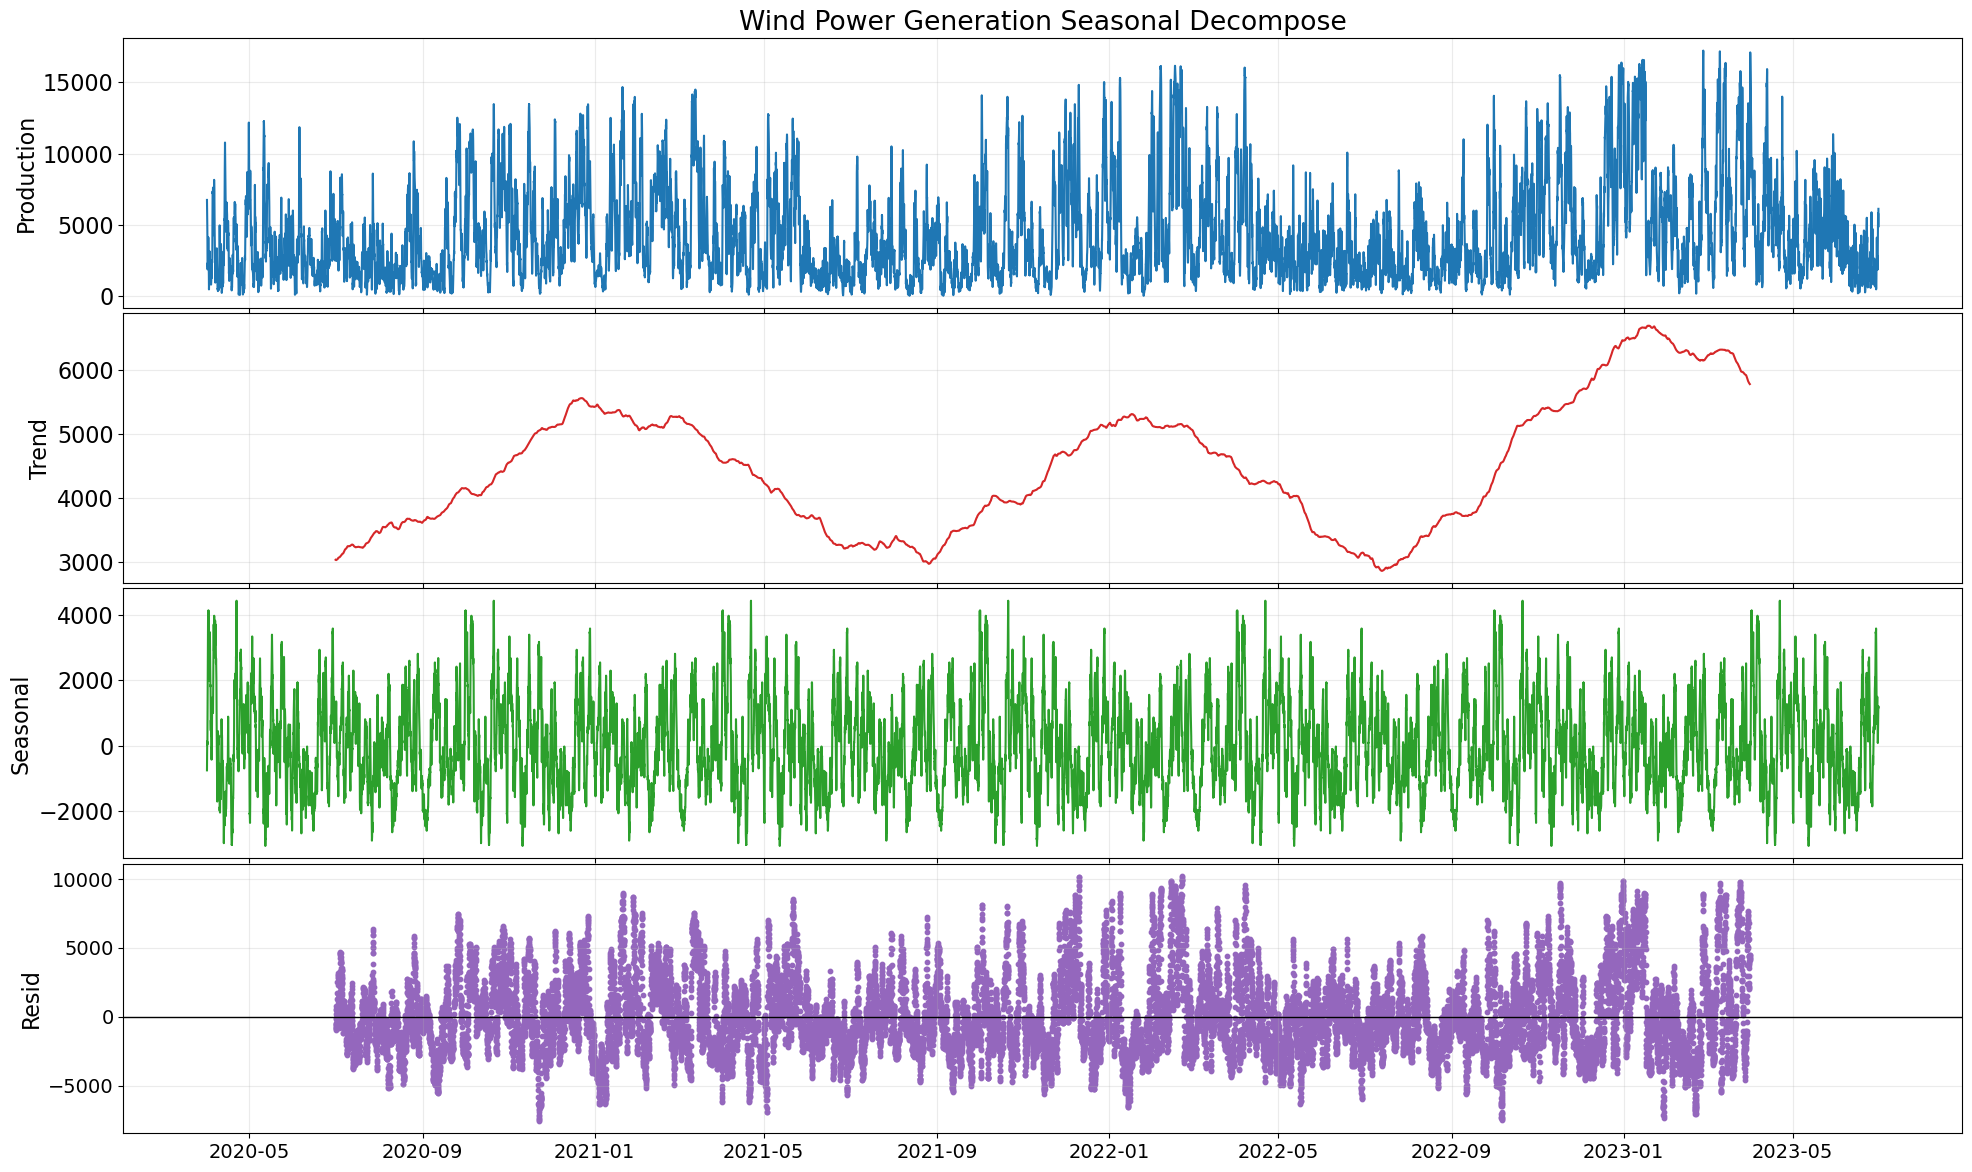

In [17]:
wind_ = wind_seasonal_decompose_plotter(wind, period=365*12, title='Wind Power Generation Seasonal Decompose', figsize=(20, 12))

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set global font size
plt.rcParams.update({'font.size': 18})  # Change 16 to your desired font size

def wind_seasonal_decompose_plotter2(df: pd.DataFrame, period=12, title='', figsize=(20, 12)):
    """
    Perform and plot seasonal decomposition of a time series.

    Parameters:
        df: DataFrame with time series data.
        col: Column name for data to decompose. Default is 'sqrt(O3 AQI)'.
        date_col: Column name for datetime values. Default is 'Date'.
        period: Seasonality period. Default is 12.

    Returns:
        A DecomposeResult object with seasonal, trend, and residual components.
    """
    # Decompostion
    decomposition = seasonal_decompose(df.values, period=period)
    de_season = decomposition.seasonal
    de_trend = decomposition.trend

    fig, ax = plt.subplots(3, sharex=True, figsize=figsize)

    ax[0].set_title(title, fontsize=20)
    ax[0].plot(df.index, df.values, color='C0')
    ax[0].set_ylabel(df.keys()[0], fontsize=18)
    ax[0].grid(alpha=0.25)
    
    ax[1].plot(df.index, de_trend, color='C3')
    ax[1].set_ylabel('Trend', fontsize=18)
    ax[1].grid(alpha=0.25)
    
    ax[2].plot(df.index, de_season, color='C2')
    ax[2].set_ylabel('Seasonal', fontsize=18)
    ax[2].grid(alpha=0.25)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout(h_pad=0)
    plt.show()
    
    return decomposition

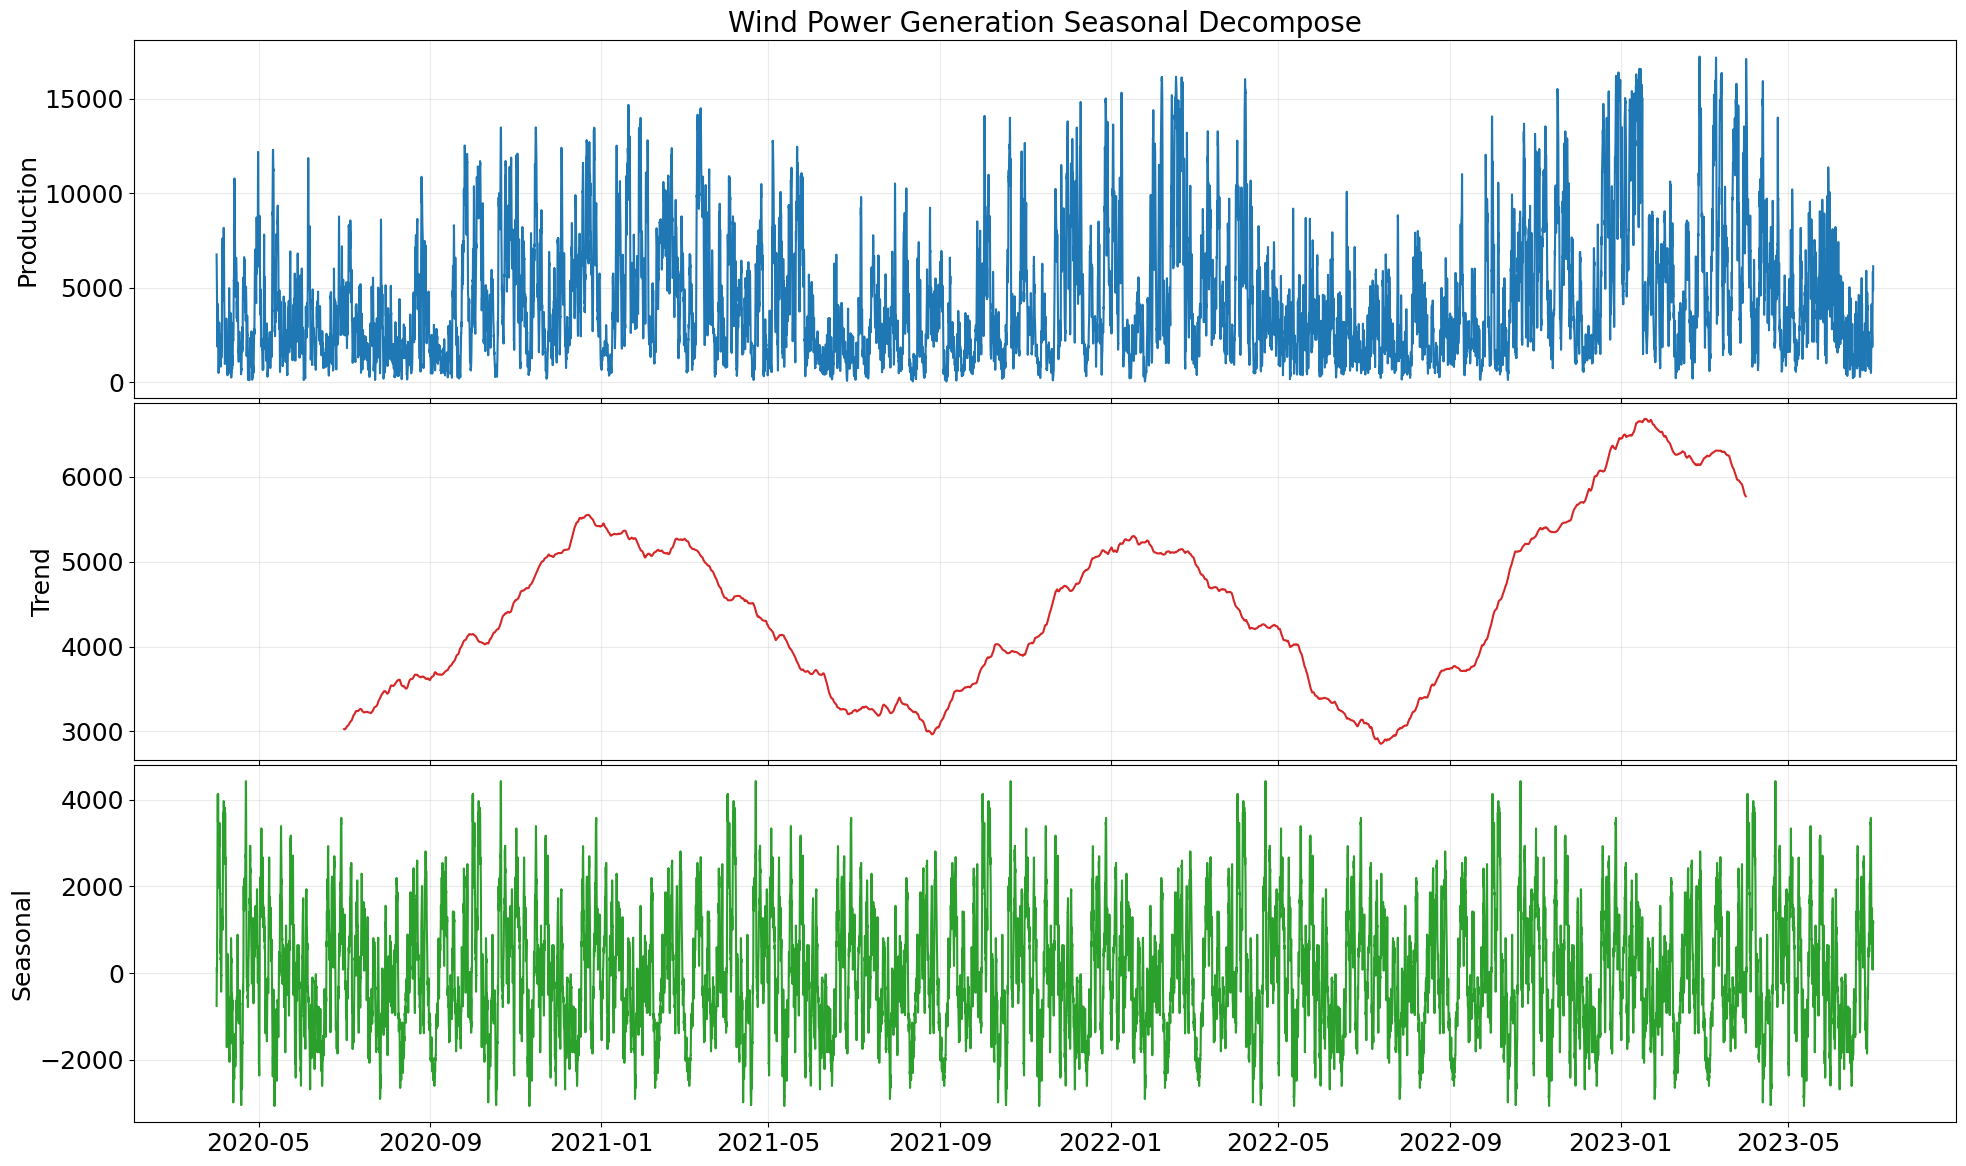

In [19]:
wind_trend = wind_seasonal_decompose_plotter2(wind, period=365*12, title='Wind Power Generation Seasonal Decompose', figsize=(20, 12))

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Set global font size
plt.rcParams.update({'font.size': 18})  # Change 16 to your desired font size

def W_seasonal_decompose_plotter(df: pd.DataFrame, period=12, title='', figsize=(20, 8)):
    """
    Perform and plot seasonal decomposition of a time series.

    Parameters:
        df: DataFrame with time series data.
        period: Seasonality period. Default is 12.
        title: Plot title.
        figsize: Figure size.

    Returns:
        A DecomposeResult object with seasonal, trend, and residual components.
    """
    # Decomposition
    decomposition = seasonal_decompose(df.values, period=period)
    de_trend = decomposition.trend

    fig, ax = plt.subplots(figsize=figsize)  # Single plot

    # Plot original data and trend together
    ax.set_title(title, fontsize=20)
    ax.plot(df.index, df.values, color='C0', label='Original Data', alpha=1)
    ax.plot(df.index, de_trend, color='C3', label='Trend', linewidth=4)
    ax.set_ylabel(df.keys()[0], fontsize=18)
    ax.grid(alpha=0.25)
    ax.legend(fontsize=16)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

    return decomposition


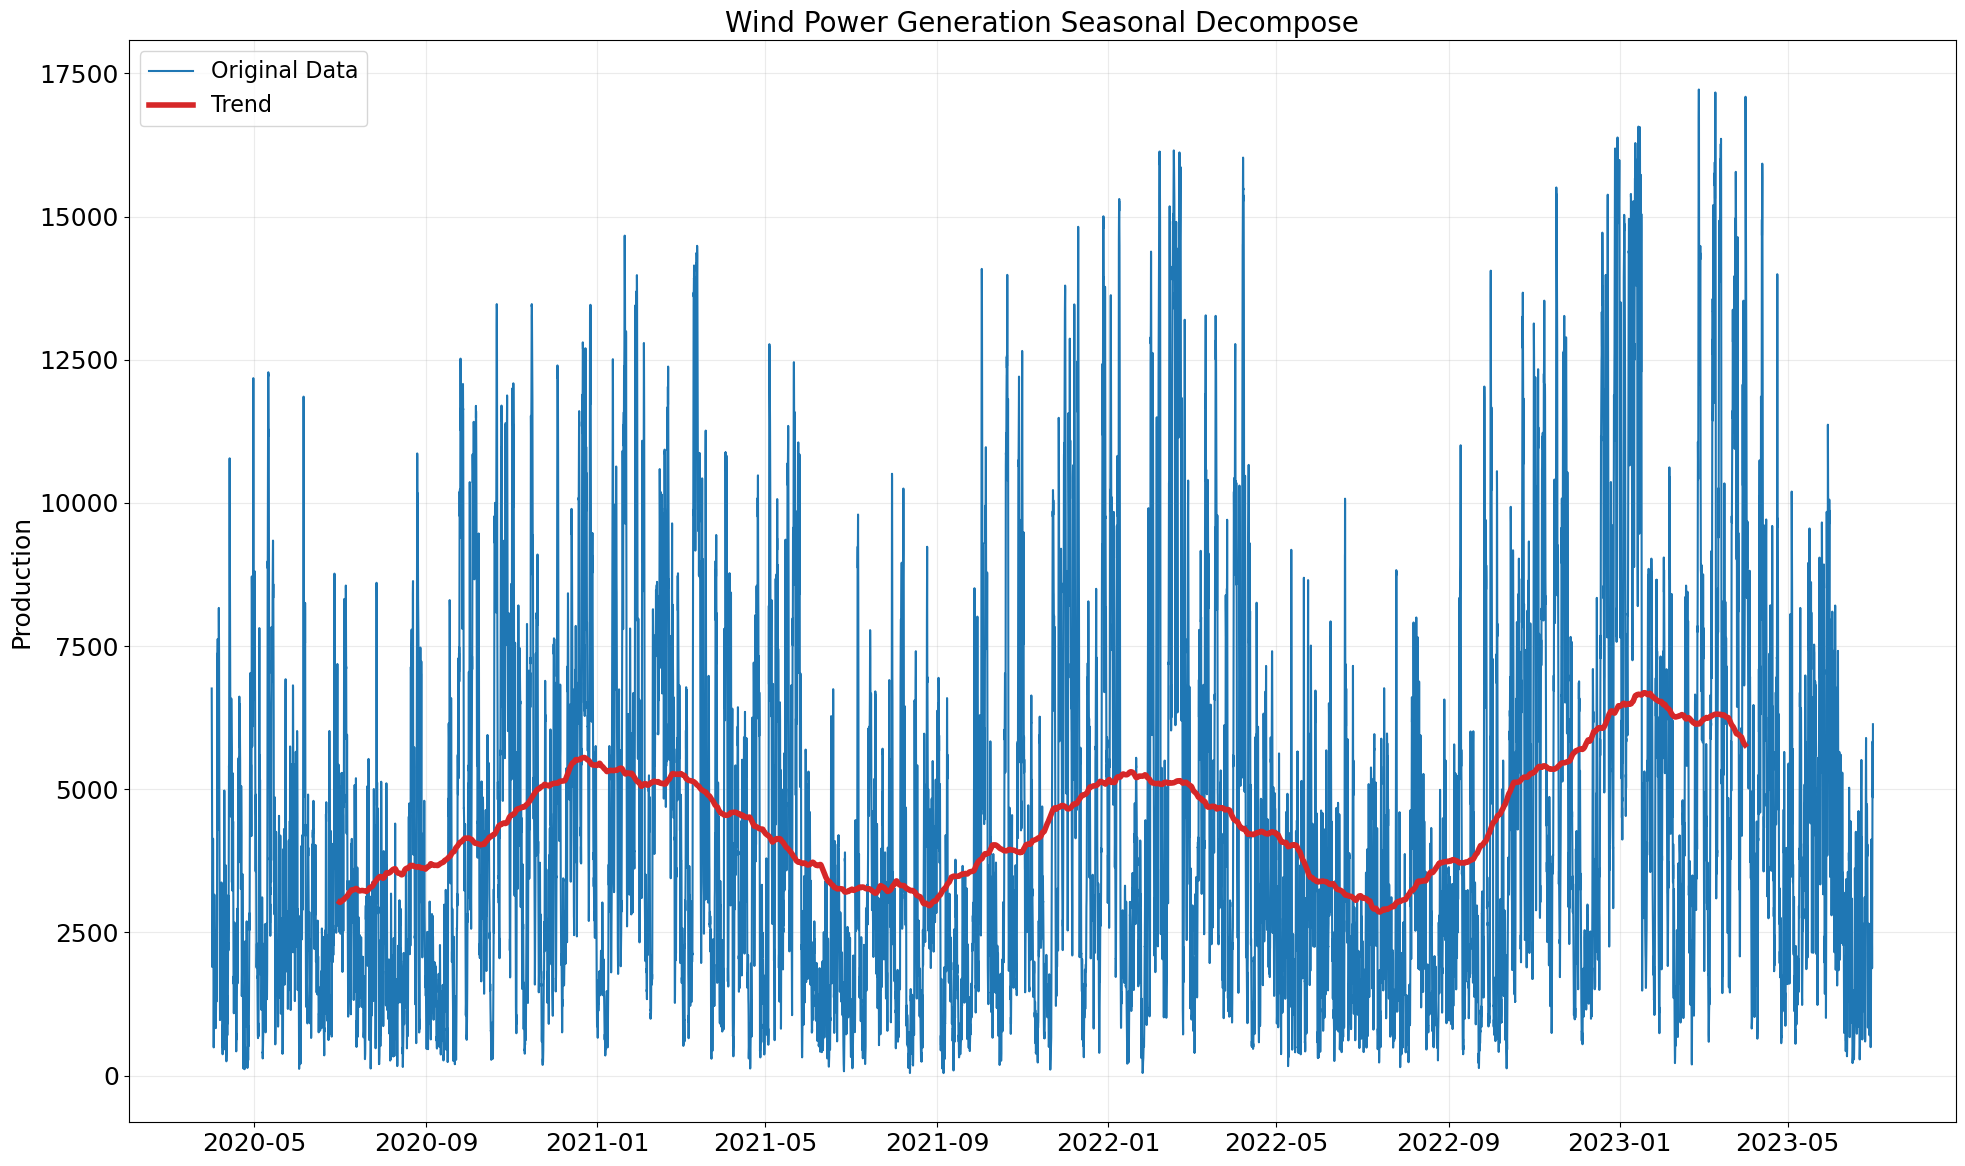

In [21]:
wind_f = W_seasonal_decompose_plotter(wind, period=365*12, title='Wind Power Generation Seasonal Decompose', figsize=(20, 12))

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Set global font size
plt.rcParams.update({'font.size': 18})  # Change 16 to your desired font size

def S_seasonal_decompose_plotter(df: pd.DataFrame, period=12, title='', figsize=(20, 8)):
    """
    Perform and plot seasonal decomposition of a time series.

    Parameters:
        df: DataFrame with time series data.
        period: Seasonality period. Default is 12.
        title: Plot title.
        figsize: Figure size.

    Returns:
        A DecomposeResult object with seasonal, trend, and residual components.
    """
    # Decomposition
    decomposition = seasonal_decompose(df.values, period=period)
    de_trend = decomposition.trend

    fig, ax = plt.subplots(figsize=figsize)  # Single plot

    # Plot original data and trend together
    ax.set_title(title, fontsize=20)
    ax.plot(df.index, df.values, color='C1', label='Original Data', alpha=1)
    ax.plot(df.index, de_trend, color='C2', label='Trend', linewidth=4)
    ax.set_ylabel(df.keys()[0], fontsize=18)
    ax.grid(alpha=0.25)
    ax.legend(fontsize=16)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

    return decomposition


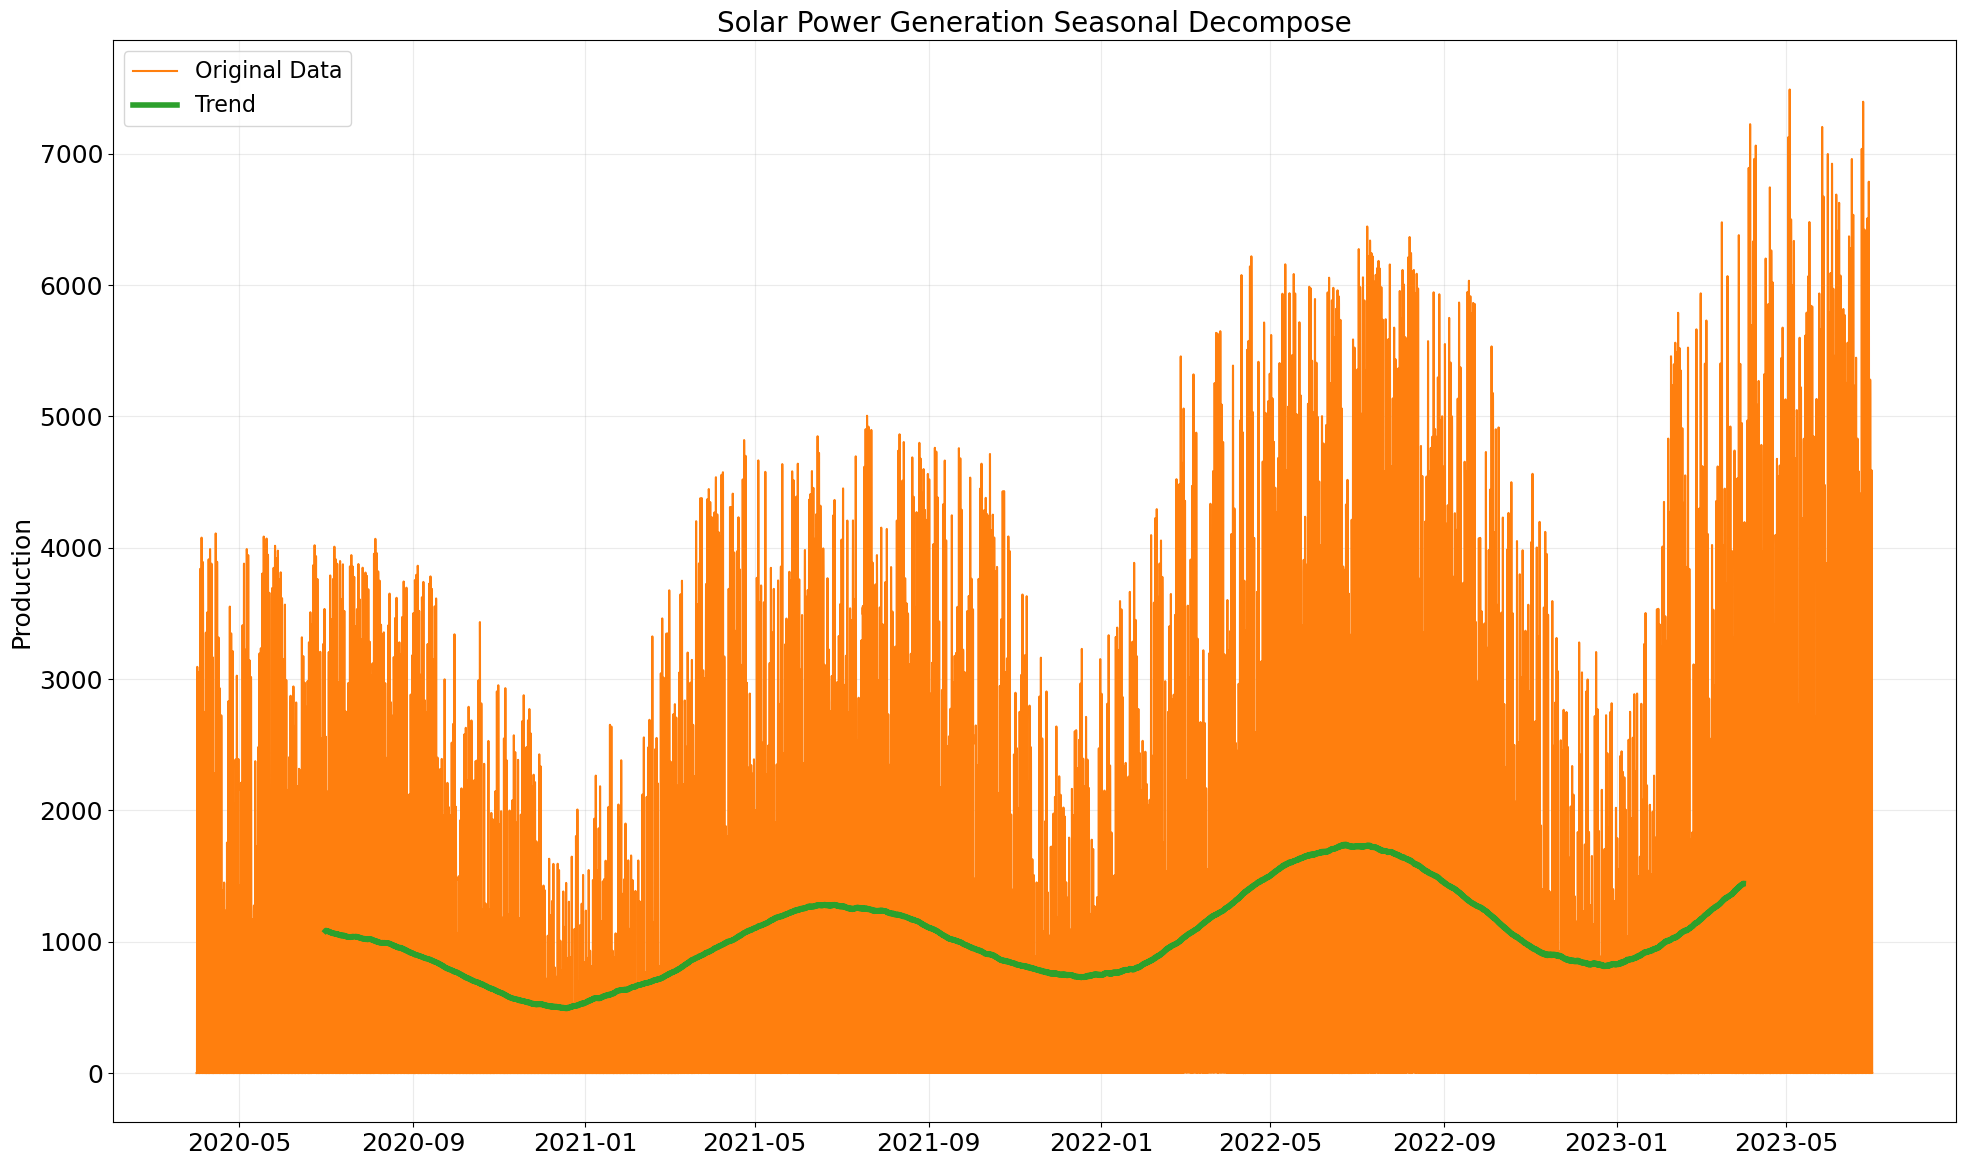

In [25]:
solar_f = S_seasonal_decompose_plotter(solar, period=365*12, title='Solar Power Generation Seasonal Decompose', figsize=(20, 12))